*Link Video :* https://drive.google.com/file/d/1Y0RxipgdDOCRJdTmSiTOGVowYKMeLZe5/view?usp=sharing 

## Import Libraries and Dataset

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Reshape, LeakyReLU, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import kerastuner as kt

# FID Library
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# Set seed
SEED = 1
tf.keras.utils.set_random_seed(SEED)

# Globl variable
IMAGE_SIZE = 100
LATENT_DIM = 100

C:\Users\asus\AppData\Local\Temp\ipykernel_31572\3248373639.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [3]:
def load_images_from_folder(folder, image_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """
    This function will return array of images that has been scalling to (-1, 1) for tanh activation
    """
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            path = os.path.join(folder, filename)
            img = load_img(path, target_size=image_size) 
            img_array = img_to_array(img)
            img_array = (img_array - 127.5) / 127.5
            images.append(img_array)
    return np.array(images, dtype=np.float32)

dataset = load_images_from_folder('../B_23/')
print(dataset.shape)

(1074, 100, 100, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


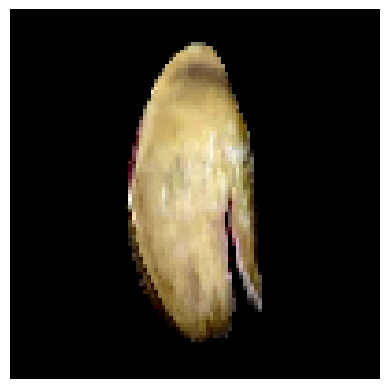

In [4]:
# Lets see our sample image after preprocessing
plt.imshow(dataset[0])
plt.axis("off")
plt.show()

## Baseline model GAN

### Create Generator

In [5]:

def build_generator(latent_dim=LATENT_DIM):
    # Input: noise vector from distribusi Gaussian
    noise = Input(shape=(latent_dim,), name='noise_input')
    
    # We use total 106 x 106 x 16 because we only use stride 1 (no upsampling), also we add extra 6 for the padding
    x = Dense(106 * 106 * 16, name='dense_proj')(noise)
    x = Reshape((106, 106, 16), name='reshape_proj')(x)
    
    # Conv layer1 (106 -> 104)
    x = Conv2D(16, kernel_size=3, strides=1, padding='valid', activation="relu")(x)
    
    # Conv layer2 (104 -> 102)
    x = Conv2D(32, kernel_size=3, strides=1, padding='valid', activation="relu")(x)
    
    # Conv layer3 (102 -> 100)
    x = Conv2D(64, kernel_size=3, strides=1, padding='valid', activation="relu")(x)
    
    # Output layer
    img = Conv2D(3,3,1,padding='same', activation='tanh')(x)
    
    return Model(inputs=noise, outputs=img, name='Generator')

### Create Discriminator

In [6]:
def build_discriminator(img_shape=(100, 100, 3)):
    
    # Input: image from generator
    img = Input(shape=img_shape, name='disc_input')
    
    # Conv layer1
    x = Conv2D(16, kernel_size=3, strides=1, padding='valid', activation="relu")(img)
    
    # Conv layer2
    x = Conv2D(32, kernel_size=3, strides=1, padding='valid', activation="relu")(x)
    
    # Conv layer3
    x = Conv2D(64, kernel_size=3, strides=1, padding='valid', activation="relu")(x)
    
    # 5. Flatten -> Fully connected single neuron + Sigmoid
    x = Flatten(name='flatten')(x)
    validity = Dense(1, activation='sigmoid', name='out')(x)
    
    return Model(inputs=img, outputs=validity, name='Discriminator')

### Compile generator and discriminator

In [7]:
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy')

discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 disc_input (InputLayer)     [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 conv2d_6 (Conv2D)           (None, 94, 94, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 565504)            0         
                                                                 
 out (Dense)                 (None, 1)                 565505    
                                                                 
Total params: 589,089
Trainable params: 589,089
Non-t

In [ ]:
# Freeze discriminator while training generator, so the discriminator doesn't get better
discriminator.trainable = False

z = Input(shape=(LATENT_DIM,))
img = generator(z)
valid = discriminator(img)

# Calculate how real the generator create image
gan = Model(z, valid, name='GAN')  # Input noise -> Generator -> Discriminator
gan.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)
gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 Generator (Functional)      (None, 100, 100, 3)       18184563  
                                                                 
 Discriminator (Functional)  (None, 1)                 589089    
                                                                 
Total params: 18,773,652
Trainable params: 18,773,652
Non-trainable params: 0
_________________________________________________________________


In [9]:
def train_gan(X_train, epochs=1000, batch_size=64, print_interval=1000):
    # lable for discriminator
    valid_labels = np.ones((batch_size, 1))
    fake_labels  = np.zeros((batch_size, 1)) 

    for epoch in range(1, epochs + 1):
        # get random image
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        
        # generate fake images
        noise = np.random.uniform(-1, 1, size=(batch_size, LATENT_DIM))
        fake_imgs = generator.predict(noise, verbose=2)

        # Update discriminator loss, if discriminator guess it wrong, the loss will increase
        d_loss_real = discriminator.train_on_batch(real_imgs, valid_labels) 
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Update generator via GAN model (because we has freeze on discriminator layer)
        g_loss  = gan.train_on_batch(noise, valid_labels)

        # print the progress
        if epoch % print_interval == 0:
            print(f"Epoch {epoch}  D-loss: {d_loss:.4f},  G-loss: {g_loss:.4f}")
            
            sample_noise = np.random.uniform(-1,1,(5, LATENT_DIM))
            gen_imgs      = generator.predict(sample_noise, verbose=0)

            # 2) denormalisasi ke [0,1] (jika kamu pakai tanh)
            gen_imgs = 0.5 * gen_imgs + 0.5

            # 3) plot 5 gambar
            fig, axes = plt.subplots(1, 5, figsize=(10,2))
            for i, ax in enumerate(axes):
                ax.imshow(gen_imgs[i])
                ax.axis('off')
            plt.suptitle(f"Epoch {epoch}")
            plt.show()

### Training GAN

Our training goals are to minimize generator loss and discriminator accuracy, so that means our generator can create a fake image dan can't be identified by discriminator.

2/2 - 9s - 9s/epoch - 4s/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 41ms/epoch - 20ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 18ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 37ms/epoch - 18ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 37ms/epoch - 19ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 32ms/ep

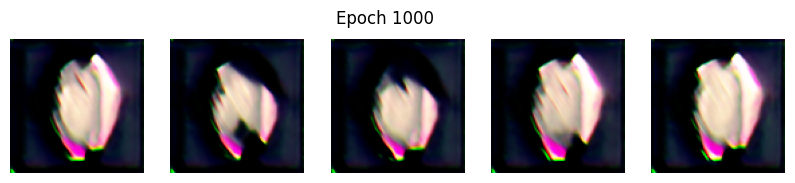

2/2 - 0s - 23ms/epoch - 12ms/step
2/2 - 0s - 24ms/epoch - 12ms/step
2/2 - 0s - 23ms/epoch - 11ms/step
2/2 - 0s - 23ms/epoch - 12ms/step
2/2 - 0s - 23ms/epoch - 11ms/step
2/2 - 0s - 23ms/epoch - 12ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 23ms/epoch - 12ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 24ms/epoch - 12ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 24ms/epoch - 12ms/step
2/2 - 0s - 23ms/epoch - 12ms/step
2/2 - 0s - 23ms/epoch - 12ms/step
2/2 - 0s - 21ms/epoch - 11ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 23ms/epoch - 12ms/step
2/2 - 0s - 23ms/epoch - 11ms/step
2/2 - 0s - 24ms/epoch - 12ms/step
2/2 - 0s - 21ms/epoch - 10ms/step
2/2 - 0s - 21ms/epoch - 11ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 21ms/epoch - 11ms/step
2/2 - 0s - 22m

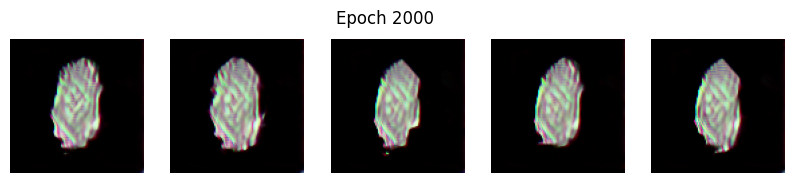

2/2 - 0s - 23ms/epoch - 12ms/step
2/2 - 0s - 23ms/epoch - 12ms/step
2/2 - 0s - 24ms/epoch - 12ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 24ms/epoch - 12ms/step
2/2 - 0s - 23ms/epoch - 11ms/step
2/2 - 0s - 22ms/epoch - 11ms/step
2/2 - 0s - 23ms/epoch - 12ms/step
2/2 - 0s - 26ms/epoch - 13ms/step
2/2 - 0s - 27ms/epoch - 13ms/step
2/2 - 0s - 24ms/epoch - 12ms/step
2/2 - 0s - 23ms/epoch - 11ms/step
2/2 - 0s - 23ms/epoch - 12ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 35ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 33ms/epoch - 17ms/step
2/2 - 0s - 36ms/epoch - 18ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 33ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 34m

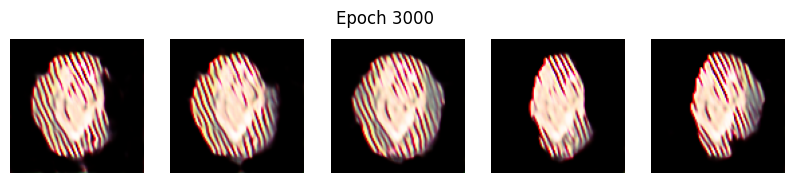

In [10]:
train_gan(dataset, epochs=3000, batch_size=64)

### Test generator & Evaluation

1/1 [==============================] - 0s 223ms/step


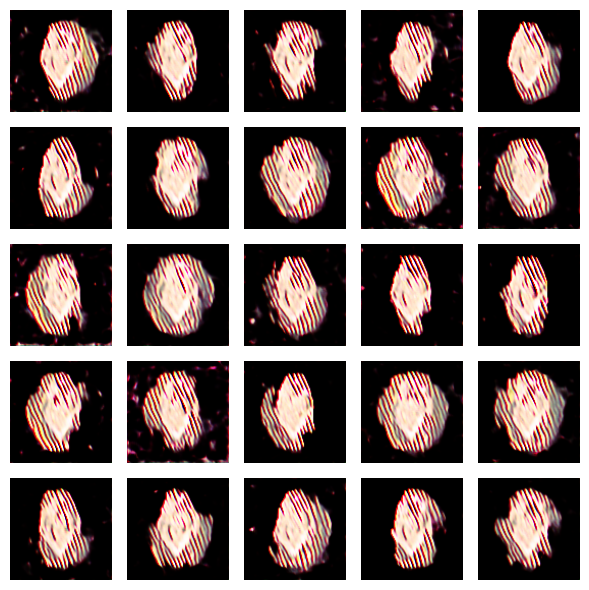

In [11]:
n_samples = 25
noise = np.random.normal(0, 1, (n_samples, 100))
gen_imgs = generator.predict(noise)

# Transform to [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

# Plotting
fig, axes = plt.subplots(5,5, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(gen_imgs[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [12]:
# Set FID with InceptionV3
inception = InceptionV3(include_top=False,
                        pooling='avg', 
                        input_shape=(100,100,3))

# Function to extract feature
def get_activations(images, batch_size=32):

    imgs = (images + 1) * 127.5
    imgs = preprocess_input(imgs) 
    act = inception.predict(imgs, batch_size=batch_size, verbose=0)
    return act  

# calculate mean and covariance
def calculate_stats(activations):
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    return mu, sigma

# Calculate the FID
def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    
    # sqrt of product covariance matrices
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

# Get real dataset and count stats
acts_real = get_activations(dataset, batch_size=32)
mu_real, sigma_real = calculate_stats(acts_real)

# Generate n sample dataset
n = dataset.shape[0]
noise = np.random.uniform(-1,1,(n, LATENT_DIM))
gen_imgs = generator.predict(noise, batch_size=32)

# Calculate generator stats
acts_fake = get_activations(gen_imgs, batch_size=32)
mu_fake, sigma_fake = calculate_stats(acts_fake)

# Calc FID
fid_value = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"FID : {fid_value:.2f}")

34/34 [==============================] - 0s 13ms/step
FID : 2219.57


## Modification Model

For modification model, we will try to Upsampling the feature map (with Conv2DTranspose) and use LeakyReLU

### Create Generator

In [ ]:
def build_generator_modified(latent_dim=100):
   # Input noise vector
   noise = Input((latent_dim,), name='noise_input')

   # Projection to feature map 25 x 25 x 256
   x = Dense(25 * 25 * 256, name='dense_proj')(noise)
   x = Reshape((25, 25, 256), name='reshape_proj')(x)
   x = LeakyReLU(name='lrelu0')(x)

   # Conv layer1
   x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', name='up1')(x)
   x = LeakyReLU(name='lrelu1')(x)

   # Conv layer2
   x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', name='up2')(x)
   x = LeakyReLU(name='lrelu2')(x)

   # Output layer
   img = Conv2D(3, kernel_size=7, padding='same', activation='tanh', name='out')(x)

   return Model(noise, img, name='GeneratorPlus')

### Create Discriminator

In [ ]:

def build_discriminator_modified(img_shape=(100,100,3)):
    # Input layer from generator
    img = Input(img_shape, name='disc_input')

    # Conv layer1
    x = Conv2D(64, kernel_size=4, strides=2, padding='same', name='conv1')(img)
    x = LeakyReLU(0.2, name='lrelu1')(x)

    # Conv layer2
    x = Conv2D(128, kernel_size=4, strides=2, padding='same', name='conv2')(x)
    x = LeakyReLU(0.2, name='lrelu2')(x)

    # Conv layer3
    x = Conv2D(256, kernel_size=4, strides=2, padding='same', name='conv3')(x)
    x = LeakyReLU(0.2, name='lrelu3')(x)

    # Pooling & Output
    x = GlobalAveragePooling2D(name='gap')(x)  # 13×13×256 → 256
    validity = Dense(1, activation='sigmoid', name='out')(x)

    return Model(img, validity, name='DiscriminatorPlus')

### Compile generator and discriminator

In [ ]:
generator_modified = build_generator_modified()
discriminator_modified = build_discriminator_modified()

discriminator_modified.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy')

discriminator_modified.summary()

Model: "DiscriminatorPlus"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 disc_input (InputLayer)     [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 64)        3136      
                                                                 
 lrelu1 (LeakyReLU)          (None, 50, 50, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 25, 25, 128)       131200    
                                                                 
 lrelu2 (LeakyReLU)          (None, 25, 25, 128)       0         
                                                                 
 conv3 (Conv2D)              (None, 13, 13, 256)       524544    
                                                                 
 lrelu3 (LeakyReLU)          (None, 13, 13, 256) 

In [ ]:
# Freeze discriminator while training generator, so the discriminator doesn't get better
discriminator_modified.trainable = False

z = Input(shape=(LATENT_DIM,))
img = generator_modified(z)
valid = discriminator_modified(img)

# Calculate how real the generator create image
gan_modified = Model(z, valid, name='GAN')  # Input noise -> Generator -> Discriminator
gan_modified.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)
gan_modified.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 GeneratorPlus (Functional)  (None, 100, 100, 3)       16824963  
                                                                 
 DiscriminatorPlus (Function  (None, 1)                659137    
 al)                                                             
                                                                 
Total params: 17,484,100
Trainable params: 16,824,963
Non-trainable params: 659,137
_________________________________________________________________


### Training GAN

In [ ]:
def train_gan(X_train, epochs=1000, batch_size=64, print_interval=1000):
    # lable for discriminator
    valid_labels = np.ones((batch_size, 1))
    fake_labels  = np.zeros((batch_size, 1)) 

    for epoch in range(1, epochs + 1):
        # get random image
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        
        # generate fake images
        noise = np.random.uniform(-1, 1, size=(batch_size, LATENT_DIM))
        fake_imgs = generator_modified.predict(noise, verbose=2)

        # Update discriminator loss, if discriminator guess it wrong, the loss will increase
        d_loss_real = discriminator_modified.train_on_batch(real_imgs, valid_labels) 
        d_loss_fake = discriminator_modified.train_on_batch(fake_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Update generator via GAN model (because we has freeze on discriminator layer)
        g_loss  = gan_modified.train_on_batch(noise, valid_labels)

        # cetak progress
        if epoch % print_interval == 0:
            print(f"Epoch {epoch}  D-loss: {d_loss:.4f},  G-loss: {g_loss:.4f}")
            
            sample_noise = np.random.uniform(-1,1,(5, LATENT_DIM))
            gen_imgs      = generator_modified.predict(sample_noise, verbose=0)

            # 2) denormalisasi ke [0,1] (jika kamu pakai tanh)
            gen_imgs = 0.5 * gen_imgs + 0.5

            # 3) plot 5 gambar
            fig, axes = plt.subplots(1, 5, figsize=(10,2))
            for i, ax in enumerate(axes):
                ax.imshow(gen_imgs[i])
                ax.axis('off')
            plt.suptitle(f"Epoch {epoch}")
            plt.show()

2/2 - 2s - 2s/epoch - 845ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 45ms/epoch - 23ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 48ms/epoch - 24ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 45ms/epoch - 22ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 49ms/epoch - 25ms/step
2/2 - 0s - 53ms/epoch - 26ms/step
2/2 - 0s - 51ms/epoch - 26ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 50ms/epoch - 25ms/step
2/2 - 0s - 50ms/epoch - 25ms/step
2/2 - 0s - 48ms/epoch - 24ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 45ms/epoch - 22ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 45ms/epoch - 22ms/step
2/2 - 0s - 48ms/epoch - 24ms/step
2/2 - 0s - 48ms/epoch - 24ms/step
2/2 - 0s - 44ms/epoch - 22ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 47ms

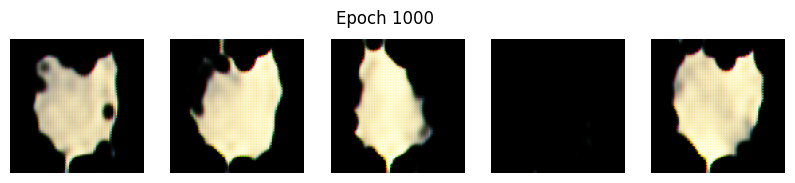

2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 44ms/epoch - 22ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 48ms/epoch - 24ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 45ms/epoch - 22ms/step
2/2 - 0s - 44ms/epoch - 22ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 49ms/epoch - 25ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 45ms/epoch - 22ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 49ms/epoch - 24ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 44m

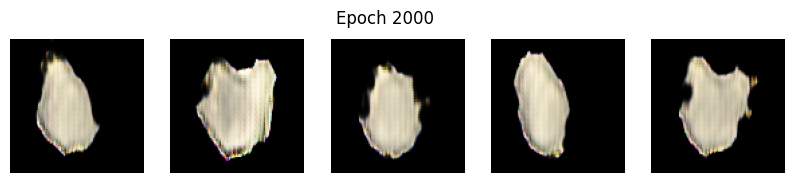

2/2 - 0s - 52ms/epoch - 26ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 48ms/epoch - 24ms/step
2/2 - 0s - 48ms/epoch - 24ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 48ms/epoch - 24ms/step
2/2 - 0s - 48ms/epoch - 24ms/step
2/2 - 0s - 48ms/epoch - 24ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 48ms/epoch - 24ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 48ms/epoch - 24ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 47m

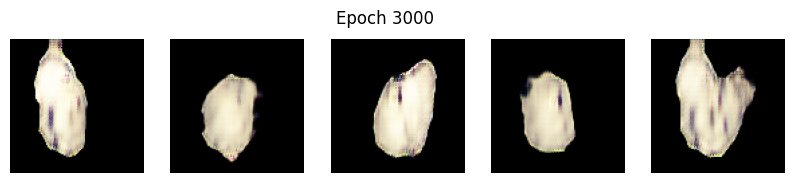

In [ ]:
train_gan(dataset, epochs=3000, batch_size=64)

### Test generator & Evaluation

1/1 [==============================] - 0s 16ms/step


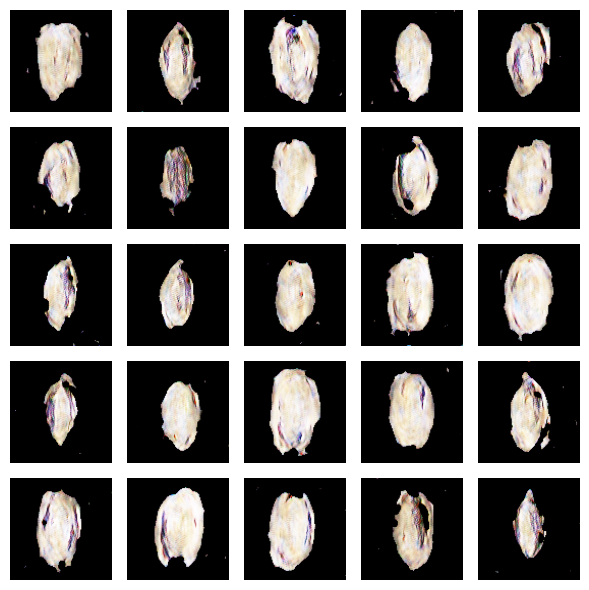

In [ ]:
n_samples = 25
noise = np.random.normal(0, 1, (n_samples, 100))
gen_imgs = generator.predict(noise)

# Transform to [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

# Plotting
fig, axes = plt.subplots(5,5, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(gen_imgs[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
acts_real = get_activations(dataset, batch_size=32)
mu_real, sigma_real = calculate_stats(acts_real)

# Generate n sample dataset
n = dataset.shape[0]
noise = np.random.uniform(-1,1,(n, LATENT_DIM))
gen_imgs = generator.predict(noise, batch_size=32)

# Calculate generator stats
acts_fake = get_activations(gen_imgs, batch_size=32)
mu_fake, sigma_fake = calculate_stats(acts_fake)

# Calc FID
fid_value = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"FID : {fid_value:.2f}")

34/34 [==============================] - 0s 10ms/step
FID : 673.53


## Hypertuning model

Because our modification show slightly better, let's try to tuning optimizer (learning rate and beta) and latent dimension

### Create Generator

In [ ]:
def build_generator_tuning(latent_dim=100, base_filter=64):
   # Input noise vector
   noise = Input((latent_dim,), name='noise_input')

   # Projection feature map 25 x 25 x base_filter(tuning)
   x = Dense(25 * 25 * base_filter, name='dense_proj')(noise)
   x = Reshape((25, 25, base_filter), name='reshape_proj')(x)
   x = LeakyReLU(name='lrelu0')(x)

   # Conv layer1
   x = Conv2DTranspose(base_filter * 2, kernel_size=4, strides=2, padding='same', name='up1')(x)
   x = LeakyReLU(name='lrelu1')(x)

   # Conv layer2
   x = Conv2DTranspose(base_filter, kernel_size=4, strides=2, padding='same', name='up2')(x)
   x = LeakyReLU(name='lrelu2')(x)

   # Output layer 
   img = Conv2D(3, kernel_size=7, padding='same', activation='tanh', name='out')(x)

   return Model(noise, img, name='GeneratorPlus')

### Create Discriminator

In [ ]:
def build_discriminator_tuning(img_shape=(100,100,3), base_filters=64):
    # Input layer from generator
    img = Input(img_shape, name='disc_input')

    # Conv layer1
    x = Conv2D(base_filters, kernel_size=4, strides=2, padding='same', name='conv1')(img)
    x = LeakyReLU(0.2, name='lrelu1')(x)

    # Conv layer2
    x = Conv2D(base_filters*2, kernel_size=4, strides=2, padding='same', name='conv2')(x)
    x = LeakyReLU(0.2, name='lrelu2')(x)

    # Conv layer3
    x = Conv2D(base_filters*4, kernel_size=4, strides=2, padding='same', name='conv3')(x)
    x = LeakyReLU(0.2, name='lrelu3')(x)

    # Pooling & Output
    x = GlobalAveragePooling2D(name='gap')(x)
    validity = Dense(1, activation='sigmoid', name='out')(x)

    return Model(img, validity, name='DiscriminatorPlus')


### Compile hyperparameter tuning

In [ ]:
class GANHyperModel(kt.HyperModel):
    def __init__(self, dataset, img_shape=(100,100,3)):
        self.dataset   = dataset
        self.img_shape = img_shape

    def build(self, hp):
        # 1) Hyperparameters to tune
        latent_dim  = hp.Choice('latent_dim', [64, 100, 128])
        g_base_filt = hp.Choice('g_base_filters',[32,  64,  128])
        d_base_filt = hp.Choice('d_base_filters',[32,  64,  128])

        # 2) Build generator & discriminator
        generator = build_generator_tuning(latent_dim, g_base_filt)
        discriminator = build_discriminator_tuning(self.img_shape, d_base_filt)

        # 3) Compile discriminator
        d_lr   = hp.Float('d_lr',   1e-5, 1e-2, sampling='log')
        d_beta = hp.Float('d_beta', 0.3,  0.7, step=0.1)
        discriminator.compile(
            optimizer=Adam(d_lr, beta_1=d_beta),
            loss='binary_crossentropy'
        )

        # 4) Freeze discriminator, build GAN
        discriminator.trainable = False
        z     = Input(shape=(latent_dim,), name='noise')
        img   = generator(z)
        valid = discriminator(img)
        gan   = Model(z, valid, name='gan_model')

        # 5) Compile GAN
        g_lr = hp.Float('g_lr', 1e-5, 1e-2, sampling='log')
        gan.compile(
            optimizer=Adam(g_lr, beta_1=d_beta),
            loss='binary_crossentropy'
        )

        # Keep references for fit function
        self.generator     = generator
        self.discriminator = discriminator

        return gan

    def fit(self, hp, model, x, y=None, **kwargs):
        X = x
        batch_size = 64
        latent_dim = hp.get('latent_dim')
        valid = np.ones((batch_size, 1))
        fake  = np.zeros((batch_size, 1))
        g_losses = []

        # simple fixed-loop training; you can adjust epochs/interval
        for epoch in range(200):  
            # 1) train discriminator
            idx = np.random.randint(0, X.shape[0], batch_size)
            real_imgs = X[idx]
            noise = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
            fake_imgs = self.generator.predict(noise, verbose=0)
            self.discriminator.train_on_batch(real_imgs, valid)
            self.discriminator.train_on_batch(fake_imgs, fake)

            # 2) train generator via GAN
            g_loss = model.train_on_batch(noise, valid)
            g_losses.append(g_loss)

        last_loss = g_losses[-1]
        return last_loss


In [ ]:
tuner = kt.RandomSearch(
    GANHyperModel(dataset, img_shape=(100,100,3)),
    objective=kt.Objective('loss', direction='min'),
    max_trials=20,
    executions_per_trial=1,
    directory='gan_tuning',
    project_name='gan_random'
)

tuner.search(
    x=dataset,
    y=None
)

# 3) Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best latent_dim:    ", best_hp.get('latent_dim'))
print("Best g_base_filters:", best_hp.get('g_base_filters'))
print("Best d_base_filters:", best_hp.get('d_base_filters'))
print("Best d_lr:          ", best_hp.get('d_lr'))
print("Best d_beta:        ", best_hp.get('d_beta'))
print("Best g_lr:          ", best_hp.get('g_lr'))

Reloading Tuner from gan_tuning\gan_random\tuner0.json
Best latent_dim:     128
Best g_base_filters: 32
Best d_base_filters: 32
Best d_lr:           1.3507964836634393e-05
Best d_beta:         0.4
Best g_lr:           0.0009435991408667303


In [ ]:
# Get best parameter
best_hp     = tuner.get_best_hyperparameters(1)[0]
latent_dim  = best_hp.get('latent_dim')
g_base_filt = best_hp.get('g_base_filters')
d_base_filt = best_hp.get('d_base_filters')
d_lr        = best_hp.get('d_lr')
d_beta      = best_hp.get('d_beta')
g_lr        = best_hp.get('g_lr')

generator_tuning = build_generator_tuning(latent_dim, g_base_filt)
discriminator_tuning = build_discriminator_tuning((100,100,3), d_base_filt)

# Compile discriminator
discriminator_tuning.compile(
    optimizer=Adam(d_lr, beta_1=d_beta),
    loss='binary_crossentropy'
)

# Freeze discriminator
discriminator_tuning.trainable = False
z = Input((latent_dim,), name='noise')
img = generator_tuning(z)
valid = discriminator_tuning(img)
gan_tuning = Model(z, valid, name='GAN_final')
gan_tuning.compile(
    optimizer=Adam(g_lr, beta_1=d_beta),
    loss='binary_crossentropy'
)

In [ ]:
def train_gan(X_train, epochs=1000, batch_size=64, print_interval=1000):
    # lable for discriminator
    valid_labels = np.ones((batch_size, 1))
    fake_labels  = np.zeros((batch_size, 1)) 

    for epoch in range(1, epochs + 1):
        # get random image
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        
        # generate fake images
        noise = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
        fake_imgs = generator_tuning.predict(noise, verbose=2)

        # Update discriminator loss, if discriminator guess it wrong, the loss will increase
        d_loss_real = discriminator_tuning.train_on_batch(real_imgs, valid_labels) 
        d_loss_fake = discriminator_tuning.train_on_batch(fake_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Update generator via GAN model (because we has freeze on discriminator layer)
        g_loss  = gan_tuning.train_on_batch(noise, valid_labels)

        # cetak progress
        if epoch % print_interval == 0:
            print(f"Epoch {epoch}  D-loss: {d_loss:.4f},  G-loss: {g_loss:.4f}")
            
            sample_noise = np.random.uniform(-1,1,(5, latent_dim))
            gen_imgs = generator_tuning.predict(sample_noise, verbose=0)

            # 2) denormalisasi ke [0,1] (jika kamu pakai tanh)
            gen_imgs = 0.5 * gen_imgs + 0.5

            # 3) plot 5 gambar
            fig, axes = plt.subplots(1, 5, figsize=(10,2))
            for i, ax in enumerate(axes):
                ax.imshow(gen_imgs[i])
                ax.axis('off')
            plt.suptitle(f"Epoch {epoch}")
            plt.show()

2/2 - 1s - 874ms/epoch - 437ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 30ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 29ms/epoch - 15ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 31ms/epoch - 16ms/step
2/2 - 0s - 34ms/epoch - 17ms/step
2/2 - 0s - 32ms/epoch - 16ms/step
2/2 - 0s - 31ms/epoch - 15ms/step
2/2 - 0s - 3

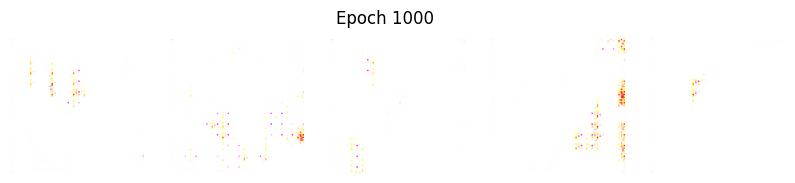

2/2 - 0s - 41ms/epoch - 21ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 39ms/epoch - 19ms/step
2/2 - 0s - 46ms/epoch - 23ms/step
2/2 - 0s - 41ms/epoch - 20ms/step
2/2 - 0s - 37ms/epoch - 18ms/step
2/2 - 0s - 45ms/epoch - 23ms/step
2/2 - 0s - 44ms/epoch - 22ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 44ms/epoch - 22ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 41ms/epoch - 21ms/step
2/2 - 0s - 39ms/epoch - 20ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 39ms/epoch - 20ms/step
2/2 - 0s - 41ms/epoch - 20ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 41ms/epoch - 21ms/step
2/2 - 0s - 47ms/epoch - 24ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 41ms/epoch - 20ms/step
2/2 - 0s - 39ms/epoch - 20ms/step
2/2 - 0s - 41ms/epoch - 21ms/step
2/2 - 0s - 39ms/epoch - 19ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 39m

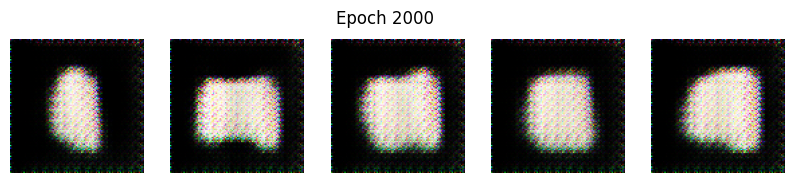

2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 41ms/epoch - 21ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 39ms/epoch - 20ms/step
2/2 - 0s - 41ms/epoch - 21ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 43ms/epoch - 22ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 41ms/epoch - 20ms/step
2/2 - 0s - 41ms/epoch - 21ms/step
2/2 - 0s - 38ms/epoch - 19ms/step
2/2 - 0s - 39ms/epoch - 20ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 44ms/epoch - 22ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 41ms/epoch - 20ms/step
2/2 - 0s - 39ms/epoch - 20ms/step
2/2 - 0s - 41ms/epoch - 21ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 39ms/epoch - 19ms/step
2/2 - 0s - 42ms/epoch - 21ms/step
2/2 - 0s - 39ms/epoch - 20ms/step
2/2 - 0s - 41ms/epoch - 20ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 40ms/epoch - 20ms/step
2/2 - 0s - 41ms/epoch - 20ms/step
2/2 - 0s - 41ms/epoch - 20ms/step
2/2 - 0s - 39m

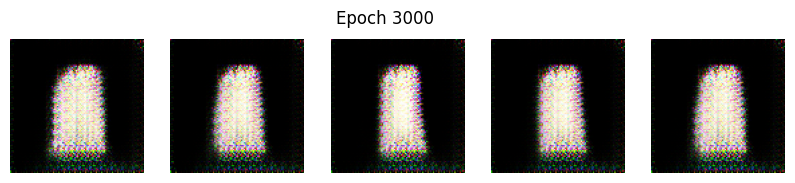

In [ ]:
train_gan(
  dataset,
  epochs=3000,
  batch_size=64,
)

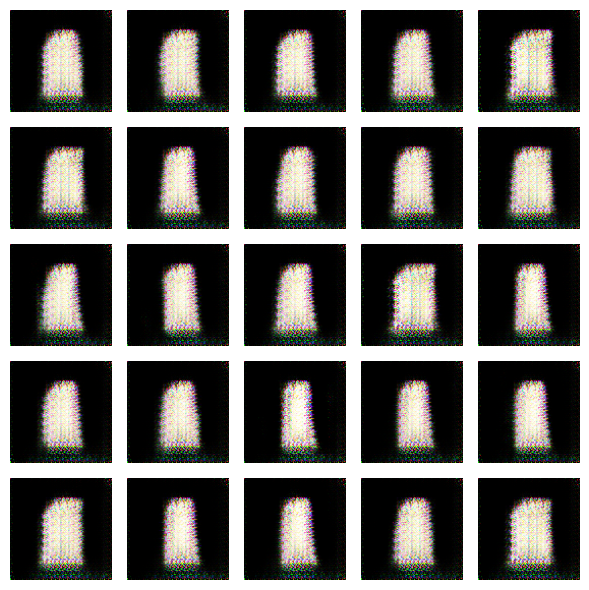

In [ ]:
n = 25
noise = np.random.normal(0,1,(n, latent_dim))
gen_imgs = generator_tuning.predict(noise, verbose=0)
gen_imgs = 0.5 * gen_imgs + 0.5   # [-1,1] → [0,1]

fig, axes = plt.subplots(5,5,figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(gen_imgs[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
acts_real = get_activations(dataset, batch_size=32)
mu_real, sigma_real = calculate_stats(acts_real)

# Generate n sample dataset
n = dataset.shape[0]
noise = np.random.uniform(-1,1,(n, latent_dim))
gen_imgs = generator_tuning.predict(noise, batch_size=32)

# Calculate generator stats
acts_fake = get_activations(gen_imgs, batch_size=32)
mu_fake, sigma_fake = calculate_stats(acts_fake)

# Calc FID
fid_value = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"FID : {fid_value:.2f}")

34/34 [==============================] - 1s 21ms/step
FID : 2729.34
